In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
import validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import PR_curve

In [2]:
data_dir='fixed_csv_label_ver2'
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


In [3]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

df_list=[]
for i in set(df['day']):
    lag=[] 
    window=5
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    lag.append(make_label(df.loc[df['day']==i, ['label']], window))
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,day,label
0,53.6,53.2,52.8,52.8,53.4,0,0
1,54.0,53.6,53.2,52.8,52.8,0,0
2,54.7,54.0,53.6,53.2,52.8,0,0
3,55.7,54.7,54.0,53.6,53.2,0,0
4,55.5,55.7,54.7,54.0,53.6,0,0
...,...,...,...,...,...,...,...
3995305,45.9,45.6,45.4,45.9,46.0,9,0
3995306,45.6,45.9,45.6,45.4,45.9,9,0
3995307,45.8,45.6,45.9,45.6,45.4,9,0
3995308,45.7,45.8,45.6,45.9,45.6,9,0


# PR曲線

## 閾値決定

0日目


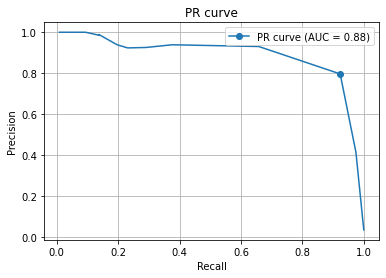

AUC：0.8813972933311773
閾値：0.10526315789473684
F値：0.8549273596957724
適合率：0.796148738379814
再現率：0.9230769230769231
-----------------------------------------------------------------------
1日目


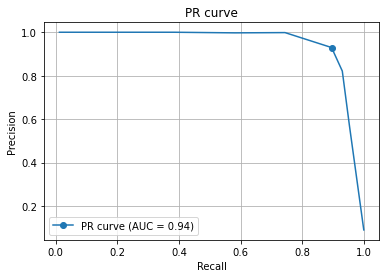

AUC：0.9396702718872505
閾値：0.15789473684210525
F値：0.9121577153888528
適合率：0.9296097934200459
再現率：0.8953488372093024
-----------------------------------------------------------------------
2日目


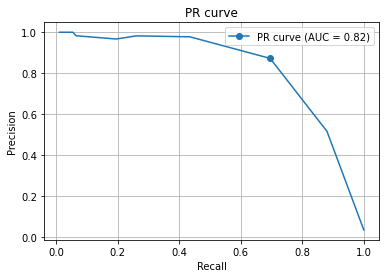

AUC：0.8181185801058071
閾値：0.10526315789473684
F値：0.7740840288583958
適合率：0.8724489795918368
再現率：0.6956521739130435
-----------------------------------------------------------------------
3日目


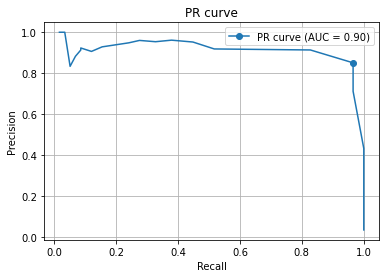

AUC：0.8953577258108075
閾値：0.15789473684210525
F値：0.9043478260869565
適合率：0.8504672897196262
再現率：0.9655172413793104
-----------------------------------------------------------------------
4日目


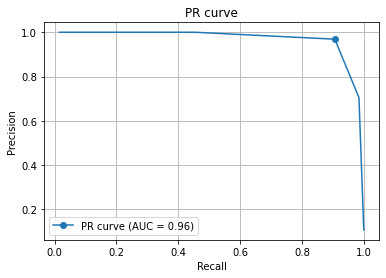

AUC：0.9552588577898343
閾値：0.10526315789473684
F値：0.9364267972209223
適合率：0.968682505399568
再現率：0.90625
-----------------------------------------------------------------------
5日目


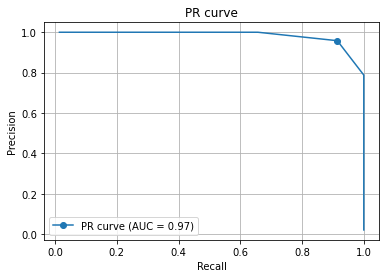

AUC：0.9694418328200141
閾値：0.15789473684210525
F値：0.9356916470708516
適合率：0.9581239530988275
再現率：0.9142857142857143
-----------------------------------------------------------------------
6日目


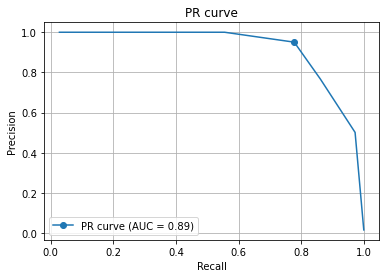

AUC：0.8937362353453041
閾値：0.15789473684210525
F値：0.8555555555555555
適合率：0.9506172839506173
再現率：0.7777777777777778
-----------------------------------------------------------------------
7日目


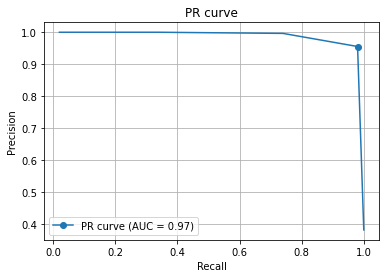

AUC：0.9668725735330316
閾値：0.05263157894736842
F値：0.9675710091701806
適合率：0.955453334947343
再現率：0.98
-----------------------------------------------------------------------
8日目


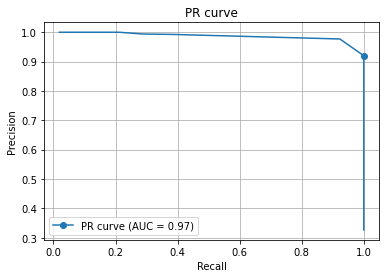

AUC：0.9677449850896404
閾値：0.05263157894736842
F値：0.9583190198099163
適合率：0.9199736176761569
再現率：1.0
-----------------------------------------------------------------------
9日目


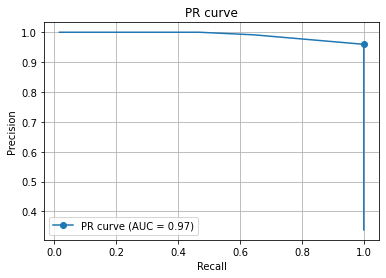

AUC：0.9743926803902294
閾値：0.10526315789473684
F値：0.9793764988009592
適合率：0.9595864661654135
再現率：1.0
-----------------------------------------------------------------------


In [4]:
thr_list=[]
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
for i in set(df['day']):
    print(f'{i}日目')
    
    test_day=[i]
    train=df[(df['label']==0)&(~df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    
    nk = 10
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    
    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
    
    d=test_v['d'].values
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = PR_curve.fig_pr(test_v, d, thr_bins)
    print(f'AUC：{auc}')
    print(f'閾値：{thr}')
    print(f'F値：{f_score.max()}')
    print(f'適合率：{p_score[np.argmax(f_score)]}')
    print(f'再現率：{r_score[np.argmax(f_score)]}')
    thr_list.append(thr)
    print('-----------------------------------------------------------------------')

In [5]:
thr_df=pd.DataFrame({'day':df['day'].unique(), 
                    'thr':thr_list})
thr_df.to_csv('day_thr.csv', index=False)

In [6]:
thr_df

,day,thr
0,0,0.105263
1,1,0.157895
2,2,0.105263
3,3,0.157895
4,4,0.105263
5,5,0.157895
6,6,0.157895
7,7,0.052632
8,8,0.052632
9,9,0.105263
